In [1]:
# number of CPUs to be used
NCPU=20

## Load and process the dataset

In [2]:
import json, gzip
import numpy as np
from sklearn.model_selection import train_test_split

aa2idx = {'A':0, 'R':1, 'N':2, 'D':3, 'C':4, 'Q':5, 'E':6, 'G':7, 'H':8, 'I':9,
          'L':10, 'K':11, 'M':12, 'F':13, 'P':14, 'S':15, 'T':16, 'W':17, 'Y':18, 'V':19}

# read .json file
with gzip.open('../data/phipsi.json.gz', 'rb') as f:
    dataset = json.loads(f.read().decode('utf-8'))

# reduse dataset to a list for simpler access
dataset = dataset['phipsi10882']

# convert data to numpy arrays skipping first and last residues
for item in dataset:
    n = len(item['sequence'])
    item['sequence'] = np.array([aa2idx[aa] for aa in item['sequence'][1:n-1]], dtype=np.int8)
    item['phi'] = np.array(item['phi'], dtype=np.float32)[1:n-1]
    item['psi'] = np.array(item['psi'], dtype=np.float32)[1:n-1]
    
    # convert (phi,psi) to their sin() and cos()
    # (4 numbers per angle pair)
    item['avec'] = np.vstack([
        np.sin(item['phi']).T,
        np.cos(item['phi']).T,
        np.sin(item['psi']).T,
        np.cos(item['psi']).T ]).T

# 90% train, 10% test
train,test = train_test_split(dataset, test_size=0.1, random_state=42)


In [3]:
%%time
from sklearn.cluster import KMeans

# split train set into 20 clusters
KMEANS = KMeans(n_clusters=20, max_iter=5, n_jobs=NCPU)
KMEANS.fit(np.vstack([item['avec'] for item in train]))

CPU times: user 1.71 s, sys: 522 ms, total: 2.23 s
Wall time: 27.5 s


## Help functions

In [4]:
# assign each (phi,psi) to a cluster
# (KMEANS stores clustering results)
def set_clusters(train, test, KMEANS):
    for subset in (train, test):
        for item in subset:
            item['abin'] = np.array(KMEANS.predict(item['avec']), dtype=np.int8)
            

In [5]:
# split all sequences into chunks of size WINDOW
def set_window(train, test, WINDOW):
    
    for subset in (train, test):
        for item in subset:
            l = len(item['sequence'])

            abin = item['abin']
            seq = item['sequence']

            # for every window, pick the element in the middle and
            # save corresponding dihedral cluster ID in item['Y']
            item['Y'] = np.hstack([item[WINDOW//2] 
                                   for shift in range(0,WINDOW,1) 
                                   for item in np.split(abin[shift:],range(0,l,WINDOW)) 
                                   if len(item) == WINDOW])

            # use 1-hot encoding for every sequence chunk
            seq_chunks = np.vstack([item for shift in range(0,WINDOW,1) 
                                    for item in np.split(seq[shift:],range(0,l,WINDOW)) 
                                    if len(item) == WINDOW])
            item['X'] = np.array(np.eye(20)[seq_chunks], dtype=np.int8).reshape((seq_chunks.shape[0],-1))
            

In [6]:
# entropy loss
def entropy_loss(Y_train, Y_test_pred):

    # background distribution
    _,counts = np.unique(Y_train, return_counts=True)
    counts = counts / Y_train.shape[0]
    H0 = np.sum(counts * np.log(counts))
    
    # predicted distribution
    H1 = np.average(np.sum(Y_test_pred * np.log(Y_test_pred), axis=1))
    
    return H1 - H0


## Randomness in clustering

K-means clustering is stochastic: each run of the algorithm can produce a different set of clusters. Here we check how this randomness affects the model performance.

In [7]:
%%time
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
WINDOW = 15

niter=100

KMEANS = []

for i in range(niter):
    
    # cluster
    KM = KMeans(n_clusters=20, max_iter=5, n_jobs=NCPU)
    KM.fit(np.vstack([item['avec'] for item in train[::5]]))
    
    set_clusters(train, test, KM)
    KMEANS.append(KM)

    set_window(train, test, WINDOW)
    
    X_train = np.vstack([item['X'] for item in train[::5]])
    Y_train = np.hstack([item['Y'] for item in train[::5]])
    X_test = np.vstack([item['X'] for item in test])
    Y_test = np.hstack([item['Y'] for item in test])

    sgd = SGDClassifier(max_iter=10, tol=1e-3, loss='log', n_jobs=NCPU)
    sgd.fit(X_train, Y_train)
    
    score_train = sgd.score(X_train, Y_train)
    score_test = sgd.score(X_test, Y_test)
    
    Y_test_pred = sgd.predict_proba(X_test)
    
    loss = log_loss(Y_test, Y_test_pred)
    hloss = entropy_loss(Y_train, Y_test_pred)

    print(i, score_train, score_test, loss, hloss)

0 0.3023280020309723 0.29951981327061505 2.215094784768515 0.3671561186467782
1 0.25435389692815435 0.2521470315729456 2.2855476259212755 0.3417179485559836
2 0.2626707286113227 0.25992445299693534 2.267965040161137 0.3324006657967429
3 0.2715841584158416 0.26904710997077896 2.249151505184583 0.3598546632288926
4 0.30587712617415586 0.3056312807355142 2.244914350473787 0.33991509971480305
5 0.34880426504188883 0.3494895231986316 2.147298504121676 0.3519227853894633
6 0.292980451891343 0.29173793742427484 2.2308134742795476 0.3513634666466783
7 0.26056613353643054 0.2591939277314518 2.2920290378540873 0.35122902288796043
8 0.31335872048743335 0.3107494120162497 2.2076489829972856 0.3317767011104604
9 0.35135059659812135 0.35077239683557837 2.142007968917102 0.354428603460224


KeyboardInterrupt: 

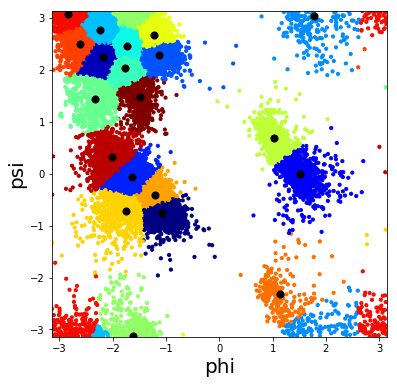

In [16]:
IDX=9

cent = KMEANS[IDX].cluster_centers_
cphi = np.arctan2(cent[:,0], cent[:,1])
cpsi = np.arctan2(cent[:,2], cent[:,3])

set_clusters(train, test, KMEANS[IDX])
set_window(train, test, WINDOW)

X_pred = KMEANS[IDX].predict(np.vstack([item['avec'] for item in train[::50]]))

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# stack phi and psi from all proteins together
# (again, use 1/50 of the full set)
phi = np.hstack([item['phi'] for item in train[::50]])
psi = np.hstack([item['psi'] for item in train[::50]])

matplotlib.rcParams['image.cmap'] = 'jet'

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])
plt.xlabel('phi', fontsize=20)
plt.ylabel('psi', fontsize=20)
plt.scatter(phi, psi, c=X_pred, s=10)
plt.scatter(cphi, cpsi, c='black', s=50)
plt.show()

In [26]:
from sklearn.neural_network import MLPClassifier

X_train = np.vstack([item['X'] for item in train])
Y_train = np.hstack([item['Y'] for item in train])
    
mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(100), verbose=1)
mlp.fit(X_train, Y_train)

Iteration 1, loss = 2.07188231
Iteration 2, loss = 2.01308359
Iteration 3, loss = 2.00074455
Iteration 4, loss = 1.99474198
Iteration 5, loss = 1.99098217
Iteration 6, loss = 1.98814567
Iteration 7, loss = 1.98609002
Iteration 8, loss = 1.98461271
Iteration 9, loss = 1.98338399
Iteration 10, loss = 1.98236576
Iteration 11, loss = 1.98136109
Iteration 12, loss = 1.98067626
Iteration 13, loss = 1.98027066
Iteration 14, loss = 1.97982337
Iteration 15, loss = 1.97936007
Iteration 16, loss = 1.97893572
Iteration 17, loss = 1.97858621
Iteration 18, loss = 1.97828430
Iteration 19, loss = 1.97798199
Iteration 20, loss = 1.97772758
Iteration 21, loss = 1.97749123
Iteration 22, loss = 1.97735342
Iteration 23, loss = 1.97709910
Iteration 24, loss = 1.97689876
Iteration 25, loss = 1.97670401
Iteration 26, loss = 1.97645078
Iteration 27, loss = 1.97641953
Iteration 28, loss = 1.97625756
Iteration 29, loss = 1.97610033
Iteration 30, loss = 1.97599598
Iteration 31, loss = 1.97572981
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=100, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=1, warm_start=False)

In [23]:
Y_test_pred = mlp.predict_proba(X_test)
loss = log_loss(Y_test, Y_test_pred)
print(loss, mlp.loss_)

2.014212297891981 2.010478515979427


## Optimal window size

In [8]:
%%time
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

KMEANS = KMeans(n_clusters=20, max_iter=5, n_jobs=NCPU)
KMEANS.fit(np.vstack([item['avec'] for item in train]))

set_clusters(train, test, KMEANS)

for WINDOW in range(1,33,2):
    set_window(train, test, WINDOW)
    
    X_train = np.vstack([item['X'] for item in train])
    Y_train = np.hstack([item['Y'] for item in train])
    X_test = np.vstack([item['X'] for item in test])
    Y_test = np.hstack([item['Y'] for item in test])
    
    sgd = SGDClassifier(max_iter=10, tol=1e-3, loss='log', n_jobs=NCPU)
    sgd.fit(X_train, Y_train)
    
    score_train = sgd.score(X_train, Y_train)
    score_test = sgd.score(X_test, Y_test)
    
    Y_test_pred = sgd.predict_proba(X_test)
    loss = log_loss(Y_test, Y_test_pred)
    hloss = entropy_loss(Y_train, Y_test_pred)

    print(WINDOW, score_train, score_test, loss, hloss)

1 0.20217837991035137 0.2021506452770061 2.5107150487896885 0.18766689267163228
3 0.22520720447781836 0.2248825579633278 2.408992948582559 0.25944257705865903
5 0.2372721609502339 0.23753324326850364 2.367115954279289 0.284624269940168
7 0.2460299658855522 0.2459778395252307 2.340816646838272 0.30568972733227096
9 0.24972906546939408 0.2501666450244557 2.3276969926992725 0.31685486102714444
11 0.2518358020723536 0.2517128974184189 2.3197511910307336 0.3333097128825049
13 0.25344224232991475 0.25252124195981895 2.3147558753519286 0.33847461266227974
15 0.2534481779856406 0.25261474591974914 2.3125384676300476 0.3337847198207773
17 0.2537981952915051 0.25302044818683145 2.3127911884813774 0.33422220796936264
19 0.2540800105637916 0.25308894339965476 2.312523284864987 0.3369036304298625
21 0.254259250519646 0.25371395013809744 2.3135956765184704 0.33628331097636144
23 0.2536866170799526 0.2528454380306232 2.314634574646013 0.34540779475231087


MemoryError: 

In [ ]:
Y_test

## Regularization strength tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

#params = {'l1_ratio' : np.linspace(0.0, 1.0, 11), 'alpha' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1] }
params = {'l1_ratio' : np.linspace(0.0, 1.0, 11)}

X_train = np.vstack([item['X'] for item in train[::10]])
Y_train = np.hstack([item['Y'] for item in train[::10]])

sgd = SGDClassifier(max_iter=100, tol=1e-3, loss='log', n_jobs=4)
hsearch = GridSearchCV(sgd, params, cv=5, verbose=2, n_jobs=5)


In [ ]:
hsearch.fit(X_train, Y_train)

In [ ]:
for mean, std, params in zip(means, stds, hsearch.cv_results_['params']):
       print("%0.5f (+/-%0.05f) for %r" % (mean, std * 2, params))

## Number of clusters